# hey

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ---------------------------------------------------------------------------- #
#                               Hyperparameters                                #
# ---------------------------------------------------------------------------- #

# Data parameters
N_FEATURES = 10000         # Total number of features in the input/output vector
K_HOT = 10                 # Number of active features (ones) in the clean input vector
NOISE_STD = 0.1            # Standard deviation of the Gaussian noise added to the input

# Model parameters
N_HIDDEN = 1000            # Number of neurons in the hidden layer
# Non-linearity: 'silu' (recommended by user, often without bias) or 'relu'
# NON_LINEARITY = 'silu'
NON_LINEARITY = 'relu'
# Bias settings for encoder and decoder (user preferred False if using SiLU)
if NON_LINEARITY == "relu":
    USE_BIAS_ENCODER = True
else:
    USE_BIAS_ENCODER = False
USE_BIAS_DECODER = False

# Loss function parameters
LOSS_WEIGHT_FACTOR_ONES = 100.0 # Weight for MSE on coordinates where target is 1
LOSS_WEIGHT_FACTOR_ZEROS = 1.0  # Weight for MSE on coordinates where target is 0

# Training parameters
LEARNING_RATE = 1e-3       # Learning rate for the optimizer
BATCH_SIZE = 2048            # Number of samples per training batch
NUM_EPOCHS = 20           # Total number of training epochs
STEPS_PER_EPOCH = 50      # Number of batches to process per epoch

# Regularization and Initialization (optional, can be tuned)
# L2 penalty on weights (0 means no L2 regularization)
WEIGHT_DECAY_ENCODER = 0.0
WEIGHT_DECAY_DECODER = 0.0
# Standard deviation for custom normal weight initialization (None uses PyTorch default)
ENCODER_INIT_SCALE = None  # e.g., 0.02
DECODER_INIT_SCALE = None  # e.g., 0.02

# Sparsity check parameters
SPARSITY_CHECK_INTERVAL = 10 # How often (in epochs) to check weight sparsity
SPARSITY_THRESHOLD = 1e-3    # Absolute value below which a weight is considered "zero"

# ---------------------------------------------------------------------------- #
#                              Data Generation                                 #
# ---------------------------------------------------------------------------- #

def generate_data_batch(batch_size, n_features, k_hot, noise_std, device):
    """
    Generates a batch of clean k-hot target vectors (x_star) and
    their noisy versions (x_noisy) for input.

    Args:
        batch_size (int): Number of samples in the batch.
        n_features (int): Dimensionality of the feature vector.
        k_hot (int): Number of '1's in the clean target vector.
        noise_std (float): Standard deviation of Gaussian noise to add.
        device (torch.device): Device to create tensors on.

    Returns:
        torch.Tensor: Noisy input vectors.
        torch.Tensor: Clean target k-hot vectors.
    """
    x_star_batch = torch.zeros(batch_size, n_features, device=device)
    for i in range(batch_size):
        # Randomly select k_hot indices to set to 1
        hot_indices = np.random.choice(n_features, k_hot, replace=False)
        x_star_batch[i, hot_indices] = 1.0

    # Add Gaussian noise to create the input vectors
    noise = torch.randn_like(x_star_batch) * noise_std
    x_noisy_batch = x_star_batch + noise

    return x_noisy_batch, x_star_batch

# ---------------------------------------------------------------------------- #
#                                Model Definition                               #
# ---------------------------------------------------------------------------- #

class SparseAutoencoder(nn.Module):
    def __init__(self, n_features, n_hidden, non_linearity_str='silu',
                 use_bias_encoder=False, use_bias_decoder=False,
                 encoder_init_scale=None, decoder_init_scale=None):
        super(SparseAutoencoder, self).__init__()

        self.encoder = nn.Linear(n_features, n_hidden, bias=use_bias_encoder)

        if non_linearity_str.lower() == 'relu':
            self.activation = nn.ReLU()
        elif non_linearity_str.lower() == 'silu':
            self.activation = nn.SiLU()
        else:
            raise ValueError("Unsupported non-linearity. Choose 'relu' or 'silu'.")

        self.decoder = nn.Linear(n_hidden, n_features, bias=use_bias_decoder)

        # Optional custom weight initialization
        if encoder_init_scale is not None:
            nn.init.normal_(self.encoder.weight, mean=0.0, std=encoder_init_scale)
            if use_bias_encoder and self.encoder.bias is not None:
                nn.init.zeros_(self.encoder.bias)
        if decoder_init_scale is not None:
            nn.init.normal_(self.decoder.weight, mean=0.0, std=decoder_init_scale)
            if use_bias_decoder and self.decoder.bias is not None:
                nn.init.zeros_(self.decoder.bias)

    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        decoded = self.decoder(encoded) # Linear output layer is typical for MSE-like targets
        return decoded

# ---------------------------------------------------------------------------- #
#                             Custom Loss Function                             #
# ---------------------------------------------------------------------------- #

class WeightedMSELoss(nn.Module):
    def __init__(self, weight_ones, weight_zeros):
        super(WeightedMSELoss, self).__init__()
        self.weight_ones = weight_ones
        self.weight_zeros = weight_zeros

    def forward(self, model_output, target_x_star):
        """
        Calculates the custom weighted MSE loss.
        Loss = 100 * (MSE on 1s) + 1 * (MSE on 0s)
        This is achieved by: sum_coords ( (W_ones - W_zeros) * x* + W_zeros ) * (output - x*)^2
        which for x*=1 gives W_ones * (output-1)^2
        and for x*=0 gives W_zeros * (output-0)^2

        Args:
            model_output (torch.Tensor): The predictions from the model.
            target_x_star (torch.Tensor): The clean k-hot target vectors.

        Returns:
            torch.Tensor: The calculated loss value.
        """
        # Create a weight matrix based on target_x_star values
        # Shape: (batch_size, n_features)
        weights = (self.weight_ones - self.weight_zeros) * target_x_star + self.weight_zeros

        squared_errors = (model_output - target_x_star)**2
        weighted_squared_errors = weights * squared_errors

        # Sum errors over all features for each sample in the batch
        loss_per_sample = torch.sum(weighted_squared_errors, dim=1)

        # Average the loss across the batch
        return torch.mean(loss_per_sample)

# ---------------------------------------------------------------------------- #
#                                Training Script                               #
# ---------------------------------------------------------------------------- #

if __name__ == "__main__":
    # Setup device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Using device: {device}")

    # Instantiate model
    model = SparseAutoencoder(
        n_features=N_FEATURES,
        n_hidden=N_HIDDEN,
        non_linearity_str=NON_LINEARITY,
        use_bias_encoder=USE_BIAS_ENCODER,
        use_bias_decoder=USE_BIAS_DECODER,
        encoder_init_scale=ENCODER_INIT_SCALE,
        decoder_init_scale=DECODER_INIT_SCALE
    ).to(device)
    print(f"🧠 Model instantiated with {N_FEATURES} features, {N_HIDDEN} hidden neurons.")
    print(f"   Activation: {NON_LINEARITY}, Encoder Bias: {USE_BIAS_ENCODER}, Decoder Bias: {USE_BIAS_DECODER}")

    # Instantiate loss function
    criterion = WeightedMSELoss(
        weight_ones=LOSS_WEIGHT_FACTOR_ONES,
        weight_zeros=LOSS_WEIGHT_FACTOR_ZEROS
    )
    print(f"📉 Loss function: Weighted MSE (Weight for 1s: {LOSS_WEIGHT_FACTOR_ONES}, Weight for 0s: {LOSS_WEIGHT_FACTOR_ZEROS})")

    # Setup optimizer with potentially different weight decays for encoder/decoder
    optimizer = optim.Adam([
        {'params': model.encoder.parameters(), 'weight_decay': WEIGHT_DECAY_ENCODER},
        {'params': model.decoder.parameters(), 'weight_decay': WEIGHT_DECAY_DECODER}
    ], lr=LEARNING_RATE)
    print(f"🛠️ Optimizer: Adam (LR: {LEARNING_RATE}, Encoder WD: {WEIGHT_DECAY_ENCODER}, Decoder WD: {WEIGHT_DECAY_DECODER})")

    print(f"\n🔥 Starting training for {NUM_EPOCHS} epochs with {STEPS_PER_EPOCH} steps per epoch...")

    encoder_percentages = []
    decoder_percentages = []
    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()  # Set model to training mode
        total_epoch_loss = 0.0

        for step in range(STEPS_PER_EPOCH):
            # Generate a new batch of data
            noisy_input, clean_target = generate_data_batch(
                BATCH_SIZE, N_FEATURES, K_HOT, NOISE_STD, device
            )

            # Forward pass
            outputs = model(noisy_input)

            # Calculate loss
            loss = criterion(outputs, clean_target)

            # Backward pass and optimization
            optimizer.zero_grad() # Clear previous gradients
            loss.backward()       # Compute gradients
            optimizer.step()      # Update weights

            total_epoch_loss += loss.item()

        avg_epoch_loss = total_epoch_loss / STEPS_PER_EPOCH
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Loss: {avg_epoch_loss:.6f}")

        # Optional: Check weight sparsity periodically
        model.eval() # Set model to evaluation mode for stable measurements
        with torch.no_grad():
            spars_threshold = 0.0 
            encoder_weights = model.encoder.weight.data
            decoder_weights = model.decoder.weight.data.T
            enc_avg_feature_act = (encoder_weights < spars_threshold).sum(dim=-1).float().mean() / encoder_weights.shape[1]
            dec_avg_feature_act = (decoder_weights < spars_threshold).sum(dim=-1).float().mean() / decoder_weights.shape[1]
            encoder_percentages.append(enc_avg_feature_act*100)
            decoder_percentages.append(dec_avg_feature_act*100)
            if (epoch + 1) % SPARSITY_CHECK_INTERVAL == 0:
                print(f"Enc: Average features/neurons active: {enc_avg_feature_act*100:.2f}%")
                print(f"Dec: Average features/neurons active: {dec_avg_feature_act*100:.2f}%")

                # enc_zeros = torch.sum(torch.abs(encoder_weights) < SPARSITY_THRESHOLD).item()
                # enc_total = encoder_weights.numel()
                # enc_sparsity = (enc_zeros / enc_total) * 100

                # dec_zeros = torch.sum(torch.abs(decoder_weights) < SPARSITY_THRESHOLD).item()
                # dec_total = decoder_weights.numel()
                # dec_sparsity = (dec_zeros / dec_total) * 100

                # print(f"  📊 Sparsity Check (threshold < {SPARSITY_THRESHOLD}):")
                # print(f"     Encoder Weights: {enc_sparsity:.2f}% near zero ({enc_zeros}/{enc_total})")
                # print(f"     Decoder Weights: {dec_sparsity:.2f}% near zero ({dec_zeros}/{dec_total})")
            model.train() # Set back to training mode

    print("\n✅ Training finished.")

    # You can add code here to save the model, further analyze weights, etc.
    # For example:
    # torch.save(model.state_dict(), "sparse_autoencoder_weights.pth")
    # print("💾 Model weights saved to sparse_autoencoder_weights.pth")

🚀 Using device: cuda
🧠 Model instantiated with 10000 features, 1000 hidden neurons.
   Activation: relu, Encoder Bias: True, Decoder Bias: False
📉 Loss function: Weighted MSE (Weight for 1s: 100.0, Weight for 0s: 1.0)
🛠️ Optimizer: Adam (LR: 0.001, Encoder WD: 0.0, Decoder WD: 0.0)

🔥 Starting training for 20 epochs with 50 steps per epoch...
Epoch [1/20], Average Loss: 884.362178
Epoch [2/20], Average Loss: 780.722177
Epoch [3/20], Average Loss: 693.466796
Epoch [4/20], Average Loss: 649.451390
Epoch [5/20], Average Loss: 630.427823
Epoch [6/20], Average Loss: 622.131403
Epoch [7/20], Average Loss: 617.486082
Epoch [8/20], Average Loss: 615.470432
Epoch [9/20], Average Loss: 614.089370
Epoch [10/20], Average Loss: 612.768564
Enc: Average features/neurons active: 51.16%
Dec: Average features/neurons active: 50.97%
Epoch [11/20], Average Loss: 612.561202
Epoch [12/20], Average Loss: 612.127651
Epoch [13/20], Average Loss: 611.658708
Epoch [14/20], Average Loss: 611.306044
Epoch [15/20],

In [9]:
# Actually check an example if i/o of model. MSE of eg 500 means what?
# output & clean_target
print(outputs[0])
print(clean_target[0])

tensor([ 0.2115,  0.1404,  0.2776,  ...,  0.2974, -0.1544, -0.0090],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


In [13]:
idxx = clean_target == 1
outputs[idxx]

tensor([-0.2525, -0.0316, -0.0339,  ...,  0.1412,  0.2338,  0.2266],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [7]:
encoder_weights = model.encoder.weight.data
acts_per_neurons = torch.zeros(encoder_weights.shape[0])
neurons_per_datapoint = []
idx = clean_target[0]==1
loop_eval = 100
for i in range(loop_eval):
    noisy_input, clean_target = generate_data_batch(
        BATCH_SIZE, N_FEATURES, K_HOT, NOISE_STD, device
    )
    z = (noisy_input@encoder_weights.T).clamp(min=0)
    acts_per_neurons += (z > 0.0).sum(dim=0).to("cpu")
    npd = (z > 0.0).sum(dim=-1).float().mean()
    neurons_per_datapoint.append(npd)
# Forward pass
# outputs = model(noisy_input)
# need to divide by batch_size & loop_eval

acts_per_neurons_normed = acts_per_neurons / (BATCH_SIZE*loop_eval)

In [8]:
# Find mean of neurons_per_datapoint
mean_neurons_per_datapoint = torch.tensor(neurons_per_datapoint).float().mean()
print(mean_neurons_per_datapoint)

tensor(500.5923)


In [ ]:
#Input 10k -> 1k-> 10k
#TODO: weight decay & mult init by scalar
# possibly Noise (0.1)

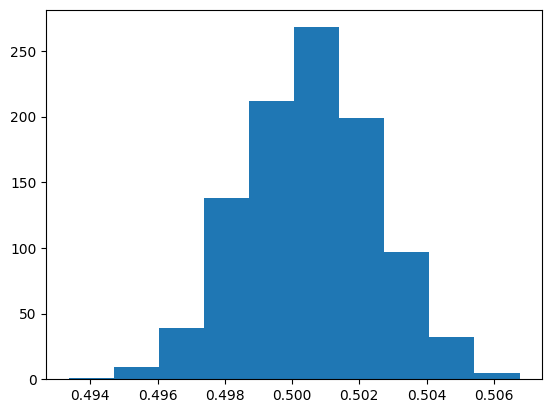

In [5]:
# plot hist of acts_per_neurons_normed
import matplotlib.pyplot as plt
plt.hist(acts_per_neurons_normed)
plt.show()

In [6]:
acts_per_neurons_normed = acts_per_neurons / (BATCH_SIZE*loop_eval)

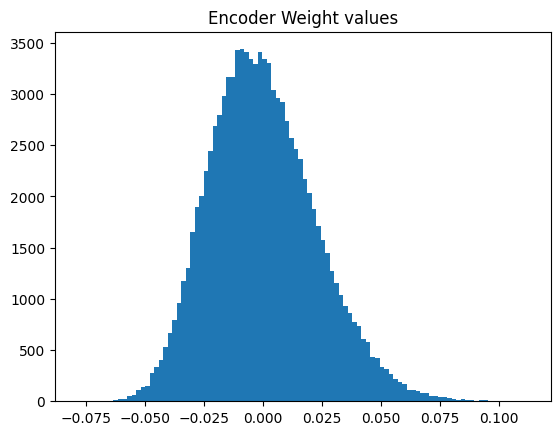

In [18]:
plt.hist(encoder_weights.flatten()[:100_000].cpu().numpy(), bins =100)
plt.title("Encoder Weight values")
plt.show()